In [1]:
'''This script pulls in salary data, builds and tests several predictive models,
   and then makes salary predictions on test data using the best model.'''
   
__author__ = 'Sam M. Mfalila'
__email__ = 'sam.mfalila@gmail.com'

In [3]:
import numpy as np 
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.pipeline import make_pipeline
import sklearn.preprocessing
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
#to adjust figsize of plots
plt.rcParams['figure.figsize'] = (20,6)

In [3]:
#Define data file path and target variable
file = 'derived_data/train_data_abt.csv'
target = 'salary'
test_features = pd.read_csv('unzipped_data/data/test_features.csv')

#list of categorical columns for numerical encoding
catcols = ['jobType', 'major', 'industry']

class Data():
    '''Loads data, samples training data if specified, assigns featues_df and target_df
    '''
    def __init__(self, file, target, sample=False, n_samples=None):
        self.file = file
        self. sample = sample
        self.n_sample = n_sample
        self.target = target
    
    def get_data(file, sample=False, n_samples=None):
        '''Loads train data with option to sample'''
        data = pd.read_csv(file)
        if sample:
            '''Sample train data due to resource limitation'''
            data = data.sample(n_samples, random_state=123)
        else:
            data = data
        print(data.shape, 'data loaded')
        return data
         
    def get_features():
        '''Assigns features dataframe'''
        features_df = data.drop(target, axis = 1)
        print(features_df.shape, 'features assigned')
        return features_df
        
    def get_target():
        '''Assigns target'''
        target_df = data[target].values
        print(target_df.shape, '...target rows loaded')
        return target_df

class FeatureSelector(BaseEstimator, TransformerMixin):
    '''Custum transformer to extract columns passed as arguments'''
    
    def __init__(self, feature_names):
        '''Class constructor'''
        self._feature_names = feature_names
        
    def fit(self, features_df, target = None):
        '''Returns self and nothing else'''
        return self
    
    def transform( self, features_df, target = None):
        '''This method returns selected features'''
        return features_df[ self._feature_names]    
    
class CategoricalFeatsAdded( BaseEstimator, TransformerMixin):
    ''' A custom transformer that adds 'lessthanHighSchool','eduAndExp', 
        and 'notEduNotExp' features
        Added option to delete redundant features
    '''
    def __init__ (self, less_than_HighSchool = False, eduAndExp = False, notEduNotExp = False):
        ''' Class constructor'''
        self._less_than_HighSchool = less_than_HighSchool
        self._eduAndExp = eduAndExp
        self._notEduNotExp = notEduNotExp
    
    def fit( self, features_df, target = None):
        ''' Returns self, nothing else is done here'''
        return self

    def transform(self, features_df, target = None):
        ''' A custom transformer that creates aformentioned features and drops redundant ones'''
    
        if self._less_than_HighSchool:
            ''' Check if needed, create new column'''
            features_df['less_than_HighSchool'] = (np.logical_and(features_df.degree == 'NONE', features_df.major == 'NONE')).astype(int)
          
        if self._eduAndExp:
            '''Check if needed'''
            features_df['eduAndexp'] = (np.logical_and(features_df.degree == 'MASTERS', features_df.yearsExperience > 5)).astype(int)
        
        if self._notEduNotExp:
            '''Check if needed'''
            features_df['notEduNotExp'] = (np.logical_and(features_df.major == 'NONE', features_df.yearsExperience < 1)).astype(int)
            '''drop redundant columns'''
            features_df.drop('yearsExperience', axis = 1)
        ''' Converting any infinity values in the dataset to Nan'''
        
        features_df = features_df.replace( [ np.inf, -np.inf ], np.nan )
        '''returns a numpy array'''    
        return features_df    
    
class CategorizeOrdinal(BaseEstimator, TransformerMixin):
    ''' A transformer to ordinal encode the 'degee' feature
        This transformer we'll encode the degree feature as follows:
        NONE:0,HIGH_SCHOOL:1, BACHELORS:2,MASTERs:3, and DOCTORAL:4 
    '''
    def __init__(self, features_df):
        self.features_df = features_df
               
    def fit(self,features_df=None, target=None):
        return self
    
    def transform(self, features_df=None, target=None):
        categories = pd.Categorical(features_df.iloc[:,1],
                                categories = ['NONE','HIGH_SCHOOL','BACHELORS','MASTERS','DOCTORAL'],
                                ordered = True)
        labels, unique = pd.factorize(categories, sort = True)
        features_df.iloc[:,1] = labels
        return features_df

class CategoricalFactorize(BaseEstimator, TransformerMixin):
    '''This class transforms categorical features using pandas pd.factorize()'''
    def __init__(self, catcols):
        self.catcols = catcols
        
    def fit(self, features_df, target=None):
        return self
    
    def transform(self, features_df, target=None):
        for c in catcols:
            encoded, categories = features_df[c].factorize()
            #replace selected column with encoded values
            features_df[c] = encoded
        return features_df.values   

class DelUnusedCols(BaseEstimator, TransformerMixin):
    '''This transformer deletes unused columns from a data pipeline
       Col 4 holds an extra column for 'yearsExperience' added through the categorical feats. pipeline.
       This row is no longer needed after new categorical features leveraging the column are engineered
    '''
    def __init__(self, features_df, target=None):
        self.features_df = features_df
        
    def fit(self, features_df, target=None):
        return self
    
    def transform(self, features_df, target=None):
        a = features_df
        a = np.delete(a,4,1)
        features_df = a
        return features_df
    
class NumericalTransformer( BaseEstimator, TransformerMixin):
    ''' Custom transformer we wrote to engineer  numerical features 
        Passed as boolean arguments to its constructor
    '''
    pass    

class StandardScalerTransformer(BaseEstimator, TransformerMixin):
    ''' This transformer standardizes all numerical features'''
    def __init__(self, features_df, target=None):
        self.features_df = features_df
        
    def fit(self, features_df, target=None):
        return self
    
    def transform(self, features_df, target=None):
        col_names = numerical_features
        features = features_df[col_names]
        scaler = StandardScaler().fit(features.values)
        features_df = scaler.transform(features.values)
        return features_df    
    
class Models(object):
    '''This class holds all modeling objects
       Note: Instantiate any additional models to test as class variables below    
    '''
    #class variables
    estimators = {}
    fitted_grid = {}
    param_grids = {}
    best_models = {}
    best_score = None
    best_model = []
    best_params = {}
    best_model_params = []
    best_model_list = []
    best_estimator = {}
    rf = RandomForestRegressor(random_state=123)
    gb = GradientBoostingRegressor(random_state = 123)
    lasso = Lasso(random_state=123)
    
    def __init__(self, master, randforest,gradboost, lso,n_iter, scoring, n_jobs, train_features):
        self.master = master
        self.randforest= randforest
        self.gradboost = gradboost
        self.lso = lso
        self.n_iter = n_iter
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.train_features   
        
    def hyperparameters(randforest=True, gradboost=True, lso=True):
        '''Defines model hyperparameters for tuning
           Add aditional models hyperparameters for tuning here as needed        
        '''
        if randforest:
            '''Setting RandomForestRegressor hyperparameters for tuning'''
            #Selecting hyperparameters for rf
            rf_n_estimators_options =[10,75,100,150,200,1000]
            rf_max_features_options = ['auto','sqrt', 'log2',  0.33]

            #Setting param grid for rf
            rf_param_grid = dict(n_estimators = rf_n_estimators_options, 
                     max_features = rf_max_features_options)
            #Adding param grid for rf to param_grids
            Models.param_grids['rf'] = rf_param_grid
        
        if gradboost:
            '''Setting GradientBoostingRegressor hyperparameters for tuning'''
            #Selecting hyperparameters for gb
            gb_n_estimators_options = [100,200]
            gb_learning_rate_options = [0.05,0.1,0.2]
            gb_max_depth_options = [1,3,5]
            subsample_options = [0.5,0.7,1.0]
            #Setting param grid for gb
            gb_param_grid = dict(learning_rate = gb_learning_rate_options,
                     n_estimators = gb_n_estimators_options,
                     subsample = subsample_options,
                     max_depth = gb_max_depth_options)
            Models.param_grids['gb'] = gb_param_grid
        
        if lso: 
            '''Setting lasso linear regression hyperparameters for tuning'''
            #Hyperparameters for lasso
            lasso_alpha_options = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
            #lasso param grid
            lasso_param_grid = dict(alpha = lasso_alpha_options)
            Models.param_grids['lasso'] = lasso_param_grid
        print("Hyperparameter grid is set")
                                                        
                
    def setting_gridsearch(randforest=True, gradboost=True, lso=True):
        '''Selects and estimators to tune and holds them in a dictionary
           Add any additional models for fiting here as needed        
        '''
        #Creating a class empty dict "estimators" to hold estimators for GridSearchCV
        #Add estimators to estimators dict
        if randforest:
            Models.estimators['rf'] = Models.rf       
        if gradboost:
            Models.estimators['gb'] = Models.gb            
        if lso:
            Models.estimators['lasso'] = Models.lasso
        print("GridSearch set and ready for fitting")
    
                
    def check_hyperparams_settings():
        '''Running code to check that hyperparameters is set up correctly.
        '''
        for key in ['rf', 'gb', 'lasso']:
            if key in Models.param_grids:
                if type(Models.param_grids[key]) is dict:
                    print( key, 'was found in hyperparameters, and it is a grid.' )
                else:
                    print( key, 'was found in hyperparameters, but it is not a grid.' )
            else:
                print( key, 'was not found in hyperparameters')

                         
    def fit_models(n_iter, scoring, n_jobs, train_features):
        '''Fits all models in GridSearch with k-folds cross validation
           cv: Number of cross validation splits
           scoring: Scoring metric
           n_jobs: Number of processors to use if parrallel processing available(-1 means using all processors)
        
           Created a class dict 'fitted_grid' to hold each of fitted model
           
           Note that GridSearch only stores results from cross_val for the last fitted model.
           We need to append results of each model fit to the dictionary above so we can access those attributes as needed.
        '''
        print('Model fitting started...')
        for Models.name, Models.estimator in Models.estimators.items():
            full_grid = RandomizedSearchCV(Models.estimators[Models.name], 
                                     Models.param_grids[Models.name], n_iter=n_iter, scoring = scoring,
                                     n_jobs = n_jobs)  
            
            #Fit data to GridSearchCV object
            full_grid.fit(train_features, target_df)    
            
            #Store fitted model
            Models.fitted_grid[Models.name] = full_grid    
            
            #Print '{name} has been fitted'
            print(Models.name,'has been fitted,')
        
        print('Model fitting completed.')
                         
    def get_best_models():
        '''loop and iterates through Models.fitted_grids dict, 
           Selects the best model name and best scores during cross validation for each estimator group, 
           and stores the name and best score for each estimator in a dict we call "best_models"
        '''
        #Best score per model
        for Models.name, Models.model in Models.fitted_grid.items():
            Models.best_models[Models.name] = ( abs(Models.model.best_score_))
        print("Best models and scores stored in best_models dict")
    
    def get_best_score():
        '''Here we create a variable "best_score" to hold the minimum mse calculated from estimator attributes strored 
           in the best_models dict above
        '''
        Models.best_score = min(Models.best_models.values())
        print('\nBest model score:', Models.best_score)
    
    def get_best_model_name():
        '''Here we create a variable "best_model" to hold the name of the model in the best_models dict that matches
           the minimum mse value stored in the variable best_score in part 2 above
        '''
        Models.best_model = [Models.key for Models.key in Models.best_models 
                             if Models.best_models[Models.key] == Models.best_score]
        
    def get_best_models_params():
        '''This code loops through our dictionary holding fitted models from cross_val ("fitted_grid") and selects the
           best model name and best hyparameter settings during cross_val for each estimator group and stores them on 
           best_params dict
        '''
        for Models.name, Models.model in Models.fitted_grid.items():
            Models.best_params[Models.name] = (Models.model.best_params_)
    
    def print_best_model_params():
        '''This code loops through the best_params dict created in step 4 above and returns paramaters
           (i.e. the value of the key) that matches name of the model stored in the best_model list created in step 3
        '''
        Models.best_model_params = [(Models.key, Models.value) for Models.key, Models.value in Models.best_params.items() 
                                    if Models.key.startswith(Models.best_model[0])]   

    def update_wining_hyperparams():
        '''Updates our best model with wining hyperparameters by
           1. Creating a dict to hold the name and hyperparameter values of our model
           2. Using .update() to update params_grid with key, values from our dict created in 1
        '''
        Models.best_model_list = [(Models.model) for Models.model, Models.params in Models.best_params.items()
                           if Models.model.startswith(Models.best_model[0])]

        '''This code creates a dict to hold the name and best params of our best model
           Creating this dict enables us to pull the key of our best model using best_model_dict[0] so we can
           use it in our next code
        '''        
        Models.best_estimator[Models.best_model_list[0]] = Models.best_params[Models.best_model[0]]    

        #Here we use the best_estimator dict created above to update param_grid with best hyerparameter values
        Models.param_grids.update(Models.best_estimator)
        print("Best model hyperparameters updated to hyperparameter grid")
        
    def save_best_model(name):
        '''Saves our best model as a pkl file
           name: Given name.pkl for saving the model
        '''
        with open(name, 'wb') as f:
            pickle.dump(Models.fitted_grid[Models.best_model[0]].best_estimator_, f)            
                            
class TestModels(object):
    #Class variables
    #Initiating the following empty dataframes as class variables
    test_df = pd.DataFrame()
    prepared_test_features = pd.DataFrame()
    pred = []
    loaded_model=[]
    
    ''' Holds all model testing objects'''
    def __init__(self, fitted_grid, best_model, data, df, test_data=True):
        self.test_data = test_data
        self.fitted_grid = fitted_grid
        self.best_model = best_model
        self.data = data
        self.n_samples = df
    
    def sample_test_df(n_samples):
        '''Samples test_df created above for testing and 
           updates TestModels.prepared_features_test
        '''
        TestModels.prepared_features_test = TestModels.test_df.sample(n_samples, random_state = 12345)
        print("prepared features for test sample", TestModels.prepared_features_test.shape)          

    def predict():
        '''Calls ppredict on test data
        '''
        #TestModels.pred = Models.fitted_grid[Models.best_model[0]].predict(data)
        TestModels.pred = TestModels.loaded_model.predict(test_features_transformed)#Use to verify loaded model works                           
        print("Predictions Returned: ", TestModels.pred)

    def load_saved_model(name):
        '''Loads saved pkl file'''
        with open(name, 'rb') as f:
            TestModels.loaded_model = pickle.load(f)
    
    def save_predictions(name):
        '''Writes predictions to csv'''
        #Add results back to test data
        test_features['salary'] = TestModels.pred        
        # Remove uneeded columns and saving to a new dataframe 'predictions'
        predictions = test_features.drop(test_features.columns[[1,2,3,4,5,6,7]], axis = 1)        
        #Write to csv without compression
        predictions.to_csv(name, index=False)
        print('Predictions saved to: ', name)
        
    def print_summary():
        '''Prints summary results for best model'''
        print('\nModel Summaries: \n')
        #for Models.name, Models.model in Models.fitted_grid.items():
            #print('\n', Models.name, 'MSE' ( abs(Models.model.best_score_))) 
        for Models.model, Models.score in Models.best_models.items():
            print('\n', Models.model, 'MSE:', round((Models.score),4))
        print('\nBest Model: ', (Models.best_model[0]))        
        print('\nBest Score: ', round(Models.best_score, 2))
        
    def get_impactful_feats(score_func, k):
        '''Calculates and returns k best impactful features'''
        #apply SelectKBest class to extract top k best features
        bestfeatures = SelectKBest(score_func=score_func, k=k)
        fit = bestfeatures.fit(np.absolute(prepared_features_df),target_df)#X values should be non-negative
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(features_df.columns)
        #concat two dataframes for better visualization
        TestModels.featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        
        TestModels.featureScores.columns = ['Feats','Score']  #naming the dataframe columns
        TestModels.featureScores = TestModels.featureScores.sort_values('Score', ascending=False) #sorting bars on plot
        print('\nBest', k, 'impactful features: \n', TestModels.featureScores.nlargest(k,'Score'))  #print k best features
        TestModels.featureScores.plot.bar() #Plot featureScores

(100000, 9) data loaded
(100000, 8) features assigned
(100000,) ...target rows loaded
Hyperparameter grid is set
GridSearch set and ready for fitting
Model fitting started...
rf has been fitted,
gb has been fitted,
lasso has been fitted,
Model fitting completed.
Best models and scores stored in best_models dict

Best model score: 357.9104414221705
Best model hyperparameters updated to hyperparameter grid
Predictions Returned:  [122.2849517  106.46774736 132.45890849 ...  95.36498755 124.13407195
 123.51536767]
Predictions saved to:  test_salaries.csv

Model Summaries: 


 rf MSE: 426.6986

 gb MSE: 357.9104

 lasso MSE: 909.8343

Best Model:  gb

Best Score:  357.91

Best 5 impactful features: 
        Feats         Score
2    jobType  32423.430658
1  companyId  17981.419343
0      jobId  11252.331634
3     degree    559.162598
4      major    400.967621


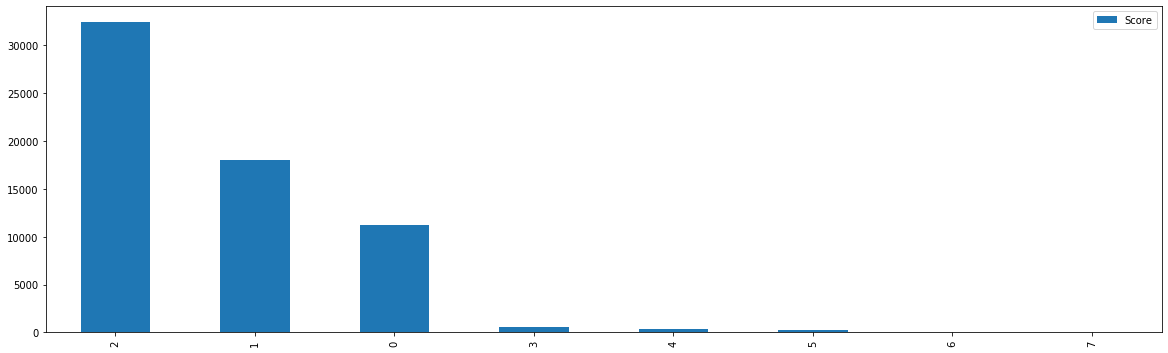

In [5]:
if __name__ == '__main__':
    
    #Load data
    data = Data.get_data(file, sample=True, n_samples = 100000)
    features_df = Data.get_features()
    target_df = Data.get_target()
    
    '''Data transformation pipelines'''
    #Categrical features to pass down categorical pipeline 
    categorical_features = ['jobType','degree', 'major', 'industry', 'yearsExperience']
    
    #Numerical features to pass down numerical pipeline 
    numerical_features = ['yearsExperience', 'milesFromMetropolis']
    
    #Define steps in categorical pipeline 
    categorical_pipeline = Pipeline( steps = [ ('cat_selector', FeatureSelector(categorical_features)),                                                                       
                                               ('cat_feats_add', CategoricalFeatsAdded()),                                                                          
                                               ('cat_ordinal', CategorizeOrdinal(features_df)),
                                              
                                               ('cat_factorize', CategoricalFactorize(catcols)),                                                                   
                                               ('delete_unused', DelUnusedCols(features_df))
                                            ])
    
    #Define steps in numerical pipeline 
    numerical_pipeline = Pipeline( steps = [ ('num_selector', FeatureSelector(numerical_features)),
                                             ('standard_trans', StandardScalerTransformer(features_df))
                                           ] )
    
    #Combine numerical and categorical pieplines horizontally using FeatureUnion
    full_pipeline = FeatureUnion( transformer_list = [ ('categorical_pipeline', categorical_pipeline), 
                                                       ('numerical_pipeline', numerical_pipeline) ] )    
    #Disable pandas chained_assignment warning
    pd.options.mode.chained_assignment = None
    
    #Fit data to data transformation pipeline
    prepared_features_df = full_pipeline.fit_transform(features_df, target)
    #print('All features_transformed successfully')
    
    #Set hyperparameters grid
    Models.hyperparameters(randforest=True,gradboost=True, lso=True)
    
    #Set RandomForest, GradientBoosting, and Lasso regressors for fit
    Models.setting_gridsearch(randforest=True,gradboost=True,lso=True)
    
    #set cross_val grid
    Models.fit_models(n_iter=5, scoring= 'neg_mean_squared_error', n_jobs = -1, 
                      train_features = prepared_features_df )    
    
    #Cross validate models, then select, fit, and score test data with best model         
    Models.get_best_models()    
    Models.get_best_score()
    Models.get_best_model_name()
    Models.get_best_models_params()
    Models.print_best_model_params()
    Models.update_wining_hyperparams()
                        
    #Save/load best model
    Models.save_best_model('final_model_salary_predictor.pkl')
    TestModels.load_saved_model('final_model_salary_predictor.pkl')
    
    #Transform test features
    #Fit data to data transformation pipeline
    test_features_transformed = full_pipeline.fit_transform(test_features)   
    
    #Predict test data
    TestModels.predict()
    
    #Write predictions to csv
    TestModels.save_predictions(name='test_salaries.csv')
    
    #Print model summaries
    TestModels.print_summary()
    
    #Get top impactful features
    TestModels.get_impactful_feats(chi2,5)

# 1. Loading Data

In [4]:
data = Data.get_data(file, sample=True, n_samples = 100000)

(100000, 9) data loaded


In [5]:
features_df = Data.get_features()

(100000, 8) features assigned


In [6]:
target_df = Data.get_target()

(100000,) ...target rows loaded


# 2. Transforming Data

<p align="center">
  <img width="460" height="400" src="Images/data_trans_pipe.PNG">
</p>

In [7]:
#Categrical features to pass down the categorical pipeline 
categorical_features = ['jobType','degree', 'major', 'industry', 'yearsExperience']

In [8]:
#Numerical features to pass down the numerical pipeline 
numerical_features = ['yearsExperience', 'milesFromMetropolis']

In [9]:
#Defining steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', FeatureSelector(categorical_features)),
                                                                                                                              
                                           ( 'cat_feats_add', CategoricalFeatsAdded()),
                                                                                                                         
                                           ('cat_ordinal', CategorizeOrdinal(features_df)),
                                          
                                           ('cat_factorize', CategoricalFactorize(catcols)),
                                                                                                                   
                                           ('delete_unused', DelUnusedCols(features_df))
                                         
                                         ])

In [10]:
#Defining the steps in the numerical pipeline 
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', FeatureSelector(numerical_features) ),
                                  
                                         ('standard_trans', StandardScalerTransformer(features_df))
                                   
                                       ] )

In [11]:
#Combining numerical and categorical piepline into one full big pipeline horizontally using FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ), 
                                                  
                                                   ( 'numerical_pipeline', numerical_pipeline  ) ] )

In [12]:
#Disabling pandas chained_assignment warning
pd.options.mode.chained_assignment = None

In [13]:
#Fitting our data to our data transformation pipeline
prepared_features_df = full_pipeline.fit_transform(features_df, target_df)

In [14]:
prepared_features_df

array([[ 0.        ,  1.        ,  0.        ,  0.        , -1.1057991 ,
         1.63424937],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  1.24873305,
         0.45812425],
       [ 2.        ,  4.        ,  1.        ,  1.        ,  0.97172927,
         0.04302127],
       ...,
       [ 7.        ,  0.        ,  0.        ,  6.        ,  1.38723494,
        -1.68657448],
       [ 4.        ,  1.        ,  0.        ,  1.        ,  1.66423873,
         1.39210596],
       [ 0.        ,  2.        ,  5.        ,  3.        ,  0.27921981,
        -1.65198257]])

# 3. Modeling Data

## Setting Hyperparameter Grids

In [15]:
#Setting hyperparameters grid
Models.hyperparameters(randforest=True,gradboost=True, lso=True)

Hyperparameter grid is set


In [16]:
#Validating hyperparameters set correctly
Models.check_hyperparams_settings()

rf was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
lasso was found in hyperparameters, and it is a grid.


## Setting GridSearch

In [19]:
#Setting up RandomForest, GradientBoosting, and Lasso regressors for fitting
Models.setting_gridsearch(randforest=True,gradboost=True,lso=True)

GridSearch set and ready for fitting


## Model Fitting

In [20]:
#Fitting models that were set manually in GridSearchCV 
Models.fit_models(n_iter=5, scoring= 'neg_mean_squared_error', n_jobs = -1,
                  train_features = prepared_features_df )

Model fitting started...
rf has been fitted,
gb has been fitted,
lasso has been fitted,
Model fitting completed.


## Model Selection

Best models and scores stored in best_models dict

Best model score: 361.9487173439982
Best model hyperparameters updated to hyperparameter grid

Model Summaries: 


 rf MSE: 424.8394

 gb MSE: 361.9487

 lasso MSE: 909.8344

Best Model:  gb

Best Score:  361.95

Best 5 impactful features: 
        Feats         Score
2    jobType  32423.430658
1  companyId  17981.419343
0      jobId  11252.331634
3     degree    559.162598
4      major    400.967621


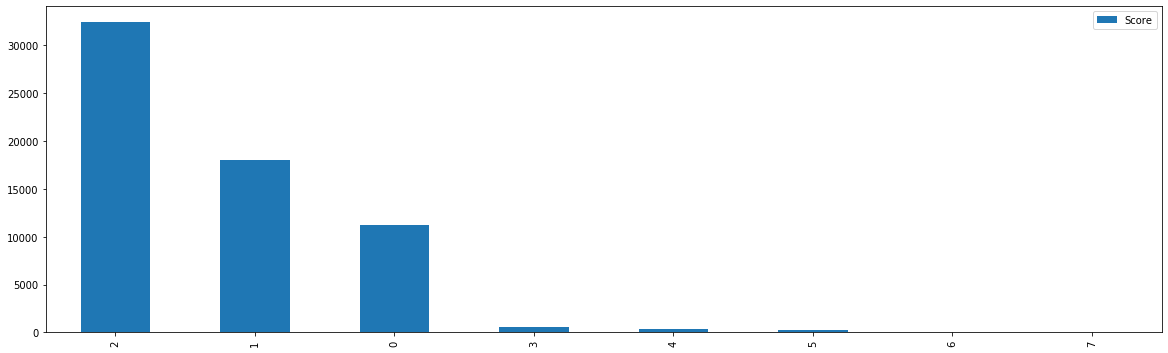

In [22]:
#Get model summeries
Models.get_best_models()    
Models.get_best_score()
Models.get_best_model_name()
Models.get_best_models_params()
Models.print_best_model_params()
Models.update_wining_hyperparams()
TestModels.print_summary()
TestModels.get_impactful_feats(chi2,5)

## Predictions

In [36]:
#Converting prepared data back to a pandas DataFrame
test_df = pd.DataFrame(data = prepared_features_df)

In [37]:
# Sampling 5 random observations to test if our model can predict
prepared_features_test = test_df.sample(5, random_state=12345)
print(prepared_features_test.shape)

(5, 6)


In [38]:
# Predict the sampled dataset using fitted best model
pred = Models.fitted_grid[Models.best_model[0]].predict(prepared_features_test)

In [39]:
pred

array([126.59756061,  58.36647686,  83.54122991, 103.5626298 ,
       134.41206148])

## Saving Best Model

In [40]:
Models.save_best_model('final_model_salary_predictor.pkl')

# 5. Testing Final Model

## Loading saved model

In [41]:
TestModels.load_saved_model('final_model_salary_predictor.pkl')

In [43]:
test_features.shape

(1000000, 8)

In [21]:
#Assessing available sys memory
!free -m

              total        used        free      shared  buff/cache   available
Mem:           9041        8576         144         109         321         118
Swap:          2047        1165         882


In [44]:
#transforming test_features
test_features_transformed = full_pipeline.fit_transform(test_features)

In [45]:
#Sanity check
test_features_transformed

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  1.38606032,
         0.81252443],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  1.10878991,
        -0.08745034],
       [ 2.        ,  3.        ,  1.        ,  0.        ,  0.69288431,
        -1.40279809],
       ...,
       [ 6.        ,  0.        ,  0.        ,  2.        , -1.52527889,
         1.43558389],
       [ 2.        ,  4.        ,  5.        ,  2.        ,  0.27697871,
         0.46638029],
       [ 1.        ,  0.        ,  0.        ,  2.        ,  0.55424911,
        -0.64128097]])

In [47]:
#Predicting test_features_transformed with our loaded saved pkl model
pred_test_results = TestModels.loaded_model.predict(test_features_transformed)

In [48]:
pred_test_results

array([118.36294886, 104.98038542, 125.65092091, ...,  95.4119308 ,
       120.37938049, 121.55133674])

### Appending results back to test dataframe

To add predictions back to the test data frame:
    - We append the predictions array to the original test dataframe
    - Delete any uneeded columns
    - Save dataframe to csv

In [49]:
test_features['salary'] = pred_test_results 

In [50]:
test_features.head() 

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73,118.362949
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47,104.980385
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9,125.650921
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96,124.749204
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44,139.121754


In [51]:
# Remove uneeded columns and saving to a new dataframe 'predictions'
predictions = test_features.drop(test_features.columns[[1,2,3,4,5,6,7]], axis = 1) 

In [52]:
predictions.head()

,jobId,salary
0,JOB1362685407687,118.362949
1,JOB1362685407688,104.980385
2,JOB1362685407689,125.650921
3,JOB1362685407690,124.749204
4,JOB1362685407691,139.121754


### Saving predictions to csv

In [53]:
#To csv without compression
predictions.to_csv('salaries.csv', index=False)

<h1><center> *END* </center></h1>
<h1><center>***Thank you!***</center></h1>